## Setup

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.stats import logistic
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## Import data

In [2]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label   

doc_stream = stream_docs(path='shuffled_movie_data.csv')

## Preprocessing

In [3]:
def preprocessing(texto):
    import re
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\n)")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    texto = REPLACE_NO_SPACE.sub('', texto.lower())
    texto = REPLACE_WITH_SPACE.sub(' ', texto)
    return texto

## Data analysis
Las palabras son analizadas mediante un histograma. Todo el dataset es analizado para este estudio.

In [4]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

def dataAnalysis(doc):
    import pandas as pd
    
    wordsP = list()
    countP = list()
    
    wordsN = list()
    countN = list()
    
    import pyprind
    pbar = pyprind.ProgBar(100)
    print('Data Analysis -----------------------\nRead text')
    for _ in range(100):
        # Getting
        x, y = get_minibatch(doc, size=500)
        
        for xs,ys in zip(x,y):
            xs = preprocessing(xs)
            
            # Positive
            if ys==1:
                for w in xs.split():
                    
                    if w in wordsP:
                        idx = wordsP.index(w)
                        countP[idx] = countP[idx] + 1
                    else:
                        wordsP.append(w)
                        countP.append(1)
                
            else:
                for w in xs.split():
                    if w in wordsN:
                        idx = wordsN.index(w)
                        countN[idx] = countN[idx] + 1
                    else:
                        wordsN.append(w)
                        countN.append(1)
                 
        # Bar
        pbar.update()
        
        
    print('\nSorting')
    positive = sorted(zip(countP,wordsP),reverse=True)
    negative = sorted(zip(countN,wordsN),reverse=True)
    
    positive = pd.DataFrame({'Word' : [w for _,w in positive],
                             'Count': [c for c,_ in positive]})
    negative = pd.DataFrame({'Word' : [w for _,w in negative],
                             'Count': [c for c,_ in negative]})
    
    return positive,negative

In [5]:
#positive,negative = dataAnalysis(doc_stream)

# Save
positive.to_csv('positive.csv',index=False)
negative.to_csv('negative.csv',index=False)

Debido a que la cantidad de palabras es muy grande, se delimita una muestra de las 1000 palabras con mayor frecuencia en los grupos de textos de sentimientos positivos y negativos.

In [6]:
# Select section
n = 2000
select_positive = positive.loc[:n,:]
select_negative = negative.loc[:n,:]

select_words_positive = select_positive['Word'].values.tolist()
select_words_negative = select_negative['Word'].values.tolist()

Ahora, analizamos que palabras aparecen más en los textos con sentimientos positivos.

In [7]:
PosNeg  = list()
coefPos = list()

Pos_Neg = list()
countPN = list()
for ip in range( len(select_positive) ):
    
    w = select_positive.loc[ip,'Word']
    
    if w in select_words_negative:
        count_pos = select_positive.loc[ip,'Count']
        count_neg = select_negative.loc[select_negative['Word'] == w,'Count'].values[0]
    
        PosNeg.append(w)
        coefPos.append( count_pos/count_neg )
    else:
        Pos_Neg.append(w)
        countPN.append( select_positive.loc[ip,'Count'] )
        
interPosNeg = pd.DataFrame({'Word' : PosNeg,'Coefficient': coefPos})
excluPosNeg = pd.DataFrame({'Word' : Pos_Neg,'Count': countPN})
    
interPosNeg = interPosNeg.sort_values('Coefficient',ascending = False).reset_index(drop=True)
excluPosNeg = excluPosNeg.sort_values('Count',ascending = False).reset_index(drop=True)

Razon entre la frecuencia de palabras en textos con sentimientos positivos, con respecto a textos con sentimientos negativos:

In [8]:
interPosNeg.head(n=8)

,Word,Coefficient
0,wonderful,4.803309
1,excellent,4.482289
2,fantastic,4.102837
3,amazing,3.815109
4,powerful,3.485401
5,favorite,3.381215
6,perfect,3.369902
7,brilliant,3.366730


Palabras que aparecen solo en los textos con sentimientos positivos:

In [9]:
excluPosNeg.head(n=8)

,Word,Count
0,superb,1092
1,beautifully,752
2,journey,693
3,subtle,675
4,touching,673
5,terrific,667
6,outstanding,642
7,bond,626


Del mismo modo, analizamos que palabras aparecen más en los textos con sentimientos negativos.

In [10]:
NegPos  = list()
coefNeg = list()

Neg_Pos = list()
countNP = list()
for ip in range( len(select_negative) ):
    
    w = select_negative.loc[ip,'Word']
    
    if w in select_words_positive:
        count_pos = select_negative.loc[ip,'Count']
        count_neg = select_positive.loc[select_positive['Word'] == w,'Count'].values[0]
    
        NegPos.append(w)
        coefNeg.append( count_pos/count_neg )
    else:
        Neg_Pos.append(w)
        countNP.append(select_negative.loc[ip,'Count'])

interNegPos = pd.DataFrame({'Word' : NegPos,'Coefficient': coefNeg})
excluNegPos = pd.DataFrame({'Word' : Neg_Pos,'Count': countNP})

interNegPos = interNegPos.sort_values('Coefficient',ascending = False).reset_index(drop=True)
excluNegPos = excluNegPos.sort_values('Count',ascending = False).reset_index(drop=True)

Razon entre la frecuencia de palabras en textos con sentimientos negativos, con respecto a textos con sentimientos positivos:

In [11]:
interNegPos.head(n=8)

,Word,Coefficient
0,worst,10.975113
1,awful,10.247458
2,terrible,6.684964
3,horrible,6.238806
4,crap,5.713793
5,worse,5.398664
6,stupid,5.212727
7,dull,4.832714


Palabras que aparecen solo en los textos con sentimientos negativos:

In [12]:
excluNegPos.head(n=8)

,Word,Count
0,waste,2590
1,poorly,1252
2,lame,1200
3,badly,1053
4,mess,1017
5,wasted,1007
6,dumb,972
7,fails,940


## Features
En esta sección se definen las características extradidas de los textos.

### Positive lexicon

Se busca si existen palabras positivas (definidas por una lista) dentro del texto.

In [13]:
def positiveLexicon(text):
    # Good words list
    with open('positive-words.txt', 'r') as f:
        goodWords = f.read().split('\n')[:-2]
    
    good = 0
    for w in text.split():
        if w in goodWords:
            good = good + 1
    
    return good

### Negative lexicon

Se busca si existen palabras negativas (definidas por una lista) dentro del texto.

In [14]:
def negativeLexicon(text):
    # Bad words list
    with open('negative-words.txt', 'r') as f:
        badWords = f.read().split('\n')[:-2]
    
    bad = 0
    for w in text.split():
        if w in badWords:
            bad = bad + 1
    
    return bad

### Does include "no"?


Verfica si existen palabras 'no','not' dentro del texto.

In [15]:
def doesIncludeNo(text):
    nos = ['no','not']
    isthereNo = 0
    for w in text.split():
        if w in nos:
            isthereNo = 1
            break
    
    return isthereNo

### Does include Pronouns (1st and 2nd)? 

Verifica que exista los pronombres de primer y segundo grado en el texto.

In [16]:
def doesIncludePronouns(text):
    pronouns = stopwords.words('english')[:17]
    isthere = 0
    for w in text.split():
        if w in pronouns:
            isthere = 1
            break
    
    return isthere

### Does include "!"? 

Verifica que exista el símbolo '!' en el texto.

In [17]:
def doesIncludeExclamationMark(text):
    return int( '!' in text )

### log(Count words)

Calcula el logaritmo de la cantidad de palabras del texto.

In [18]:
def logCountWords(text):
    return np.log( len(text.split()) )

### Does include More Positives?

Verifica que el texto incluya palabras que se encuentran principalmente en textos con sentimientos positivos.

In [19]:
def morePositives(text):
    import pandas as pd
    df = pd.read_csv('interPosNeg.csv')
    positives = df.loc[:10,'Word'].values.tolist()
    
    df = pd.read_csv('excluPosNeg.csv')
    positives = positives + df.loc[:10,'Word'].values.tolist()
    
    isthere = 0
    for w in text.split():
        if w in positives:
            isthere = 1
            break
    
    return isthere

### Does include More Negatives?

Verifica que el texto incluya palabras que se encuentran principalmente en textos con sentimientos negativos.

In [20]:
def moreNegatives(text):
    import pandas as pd
    df = pd.read_csv('interNegPos.csv')
    negatives = df.loc[:30,'Word'].values.tolist()
    
    df = pd.read_csv('excluNegPos.csv')
    negatives = negatives + df.loc[:2,'Word'].values.tolist()
    
    isthere = 0
    for w in text.split():
        if w in negatives:
            isthere = 1
            break
    
    return isthere

### How much include More Positives?

Calcula la cantidad de palabras, que se encuentran principalmente en textos con sentimientos positivos, existen en el texto.

In [21]:
def howMuchPositives(text,interPosNeg,excluPosNeg):
    positives = interPosNeg.loc[:30,'Word'].values.tolist()
    positives = positives + excluPosNeg.loc[:2,'Word'].values.tolist()
    
    count = 0
    for w in text.split():
        if w in positives:
            count = count + 1

    return count

### How much include More Negatives?

Calcula la cantidad de palabras, que se encuentran principalmente en textos con sentimientos negativos, existen en el texto.

In [22]:
def howMuchNegatives(text,interNegPos,excluNegPos):
    negatives = interNegPos.loc[:30,'Word'].values.tolist()
    negatives = negatives + excluNegPos.loc[:2,'Word'].values.tolist()
    
    count = 0
    for w in text.split():
        if w in negatives:
            count = count + 1
    
    return count

### How much include More Positives? (ratio)

Calcula la razón de palabras, que se encuentran principalmente en textos con sentimientos positivos, existen en el texto.

In [51]:
def howMuchPositivesRatio(text,interPosNeg,excluPosNeg):
    positives = interPosNeg.loc[:30,'Word'].values.tolist()
    positives = positives + excluPosNeg.loc[:2,'Word'].values.tolist()
    
    countPost = 0
    countWord = 0
    for w in text.split():
        countWord = countWord + 1
        if w in positives:
            countPost = countPost + 1
    
    return countPost/countWord

### How much include More Negatives? (ratio)

Calcula la razón de palabras, que se encuentran principalmente en textos con sentimientos negativos, existen en el texto.

In [52]:
def howMuchNegativesRatio(text,interNegPos,excluNegPos):
    negatives = interNegPos.loc[:30,'Word'].values.tolist()
    negatives = negatives + excluNegPos.loc[:2,'Word'].values.tolist()
    
    countNega = 0
    countWord = 0
    for w in text.split():
        countWord = countWord + 1
        if w in negatives:
            countNega = countNega + 1
    
    return countNega/countWord

### Generate features

Son extraidas las características de los textos.

In [53]:
doc_stream = stream_docs(path='shuffled_movie_data.csv')

x = list()
y = list()
for _ in range(50):
    # Getting
    x_raw, y_raw = get_minibatch(doc_stream, size=1000)
    
    # Update features
    features = [ [ positiveLexicon           (preprocessing(text)),
                   negativeLexicon           (preprocessing(text)),
                   doesIncludeNo             (preprocessing(text)), 
                   doesIncludePronouns       (preprocessing(text)),
                   doesIncludeExclamationMark(preprocessing(text)),
                   logCountWords             (preprocessing(text)),
                   morePositives             (preprocessing(text)),
                   moreNegatives             (preprocessing(text)),
                   howMuchPositives          (preprocessing(text),
                                                      interPosNeg,
                                                      excluPosNeg),
                   howMuchNegatives          (preprocessing(text),
                                                      interNegPos,
                                                      excluNegPos),
                   howMuchPositivesRatio     (preprocessing(text),
                                                      interPosNeg,
                                                      excluPosNeg),
                   howMuchNegativesRatio     (preprocessing(text),
                                                      interNegPos,
                                                      excluNegPos)] for text in x_raw ] 
    x = x + features
    
    # Update out
    y = y + y_raw

Las características son analizadas con correlación.

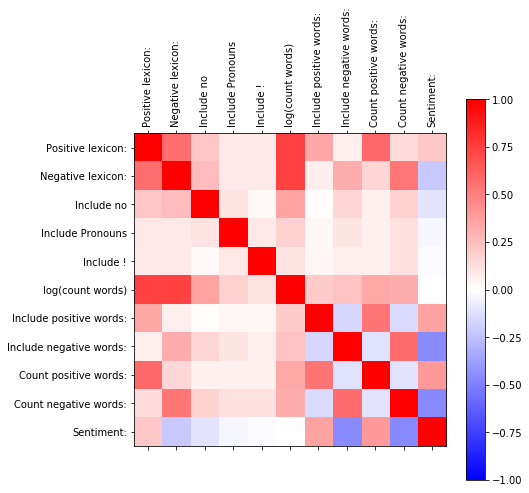

In [37]:
data ={'Positive lexicon:'      : [xs[0] for xs in x],
       'Negative lexicon:'      : [xs[1] for xs in x],
       'Include no'             : [xs[2] for xs in x],
       'Include Pronouns'       : [xs[3] for xs in x],
       'Include !'              : [xs[4] for xs in x],
       'log(count words)'       : [xs[5] for xs in x],
       'Include positive words:': [xs[6] for xs in x],
       'Include negative words:': [xs[7] for xs in x],
       'Count positive words:'  : [xs[8] for xs in x],
       'Count negative words:'  : [xs[9] for xs in x],
       'Sentiment:'             : y}

data = pd.DataFrame(data)

# Calcule correlation
import matplotlib.pyplot as plt
corr = data.corr()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='bwr', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

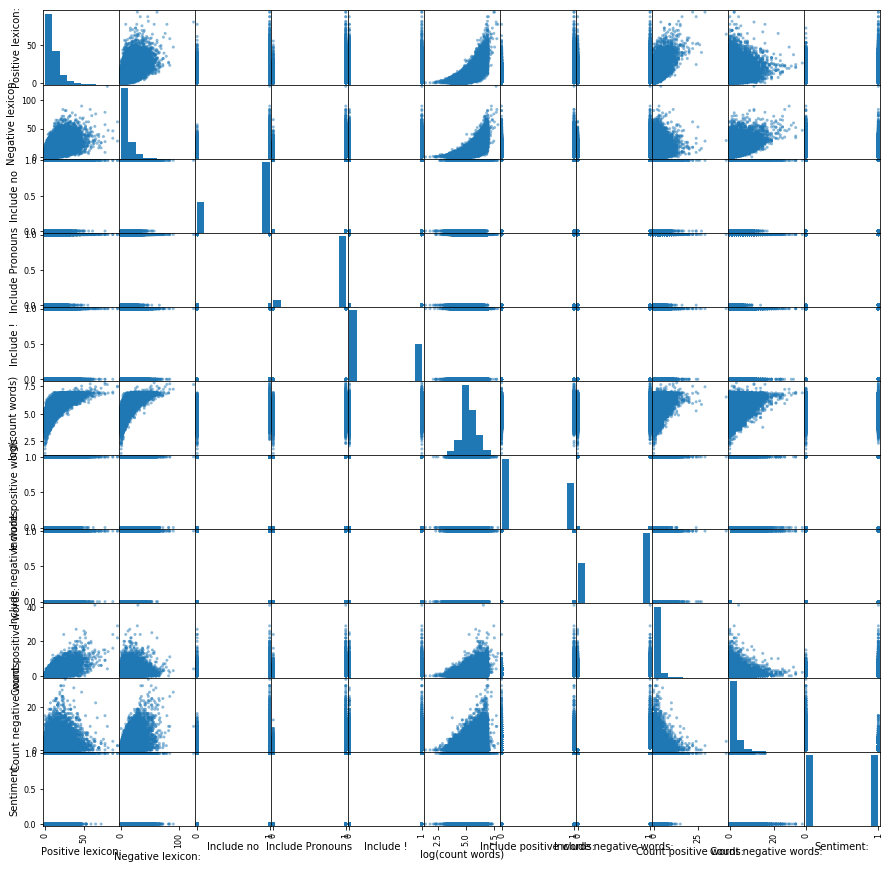

In [48]:
pd.scatter_matrix(data, figsize=(15,15))
plt.show()

## Logistic Regression

### Stochastic Gradient Descent

El modelo es entrenado mediante una gradiente descendiente.

In [66]:
def StochasticGradientDescent(x_train,y_train):
    import random
    from scipy.stats import logistic
    
    # Parameters
    eta       = 0.001
    err       = 1000
    errNorm   = 1000
    threshold = 0.00001
    
    n_samples  = len(x_train   )
    n_features = len(x_train[0])
    
    w = np.zeros(n_features + 1)
    
    # Train Loop
    while (errNorm>threshold):
        exErr = err
        
        # Random selection
        n = round(random.uniform(0, n_samples-1))
        try:
            xs = np.array( x_train[n] + [1] )
        except:
            print('n: ',n)
            print('n_samples: ',n_samples)
            
        ys = y_train[n]
        
        # Hypotesis
        h = logistic.cdf( np.dot(xs,w) ) 
        
        # Gradient
        g = (h - ys)*xs
        
        # Update
        w = w - eta*g
        
        # Prediction
        y_pred = w*xs
        
        # Error
        err = np.sum(np.abs(ys - y_pred))
        
        # Update error
        errNorm = np.abs(exErr - err)/np.abs(err)
        
    return w

def applyModel(x,w):      
    
    y_pred = list()
    for xs in x:
        ys =  logistic.cdf( np.dot( np.array(xs + [1]),w ) ) 
        
        y_pred.append(ys)
    
    return y_pred

### Train and test

Mediante validación cruzada, se realiza el entrenamiento y testeo del modelo.

In [75]:
kf = KFold(n_splits=8)  
prediction = list()
for train, test in kf.split(x):
    
    # Select
    x_train = [ x[i] for i in train ]
    y_train = [ y[i] for i in train ]
    
    x_test = [ x[i] for i in test ]
    y_test = [ y[i] for i in test ]
    
    # Run train
    w = StochasticGradientDescent(x_train, y_train)
    
    # Run test
    y_pred = applyModel(x_test,w)
    
    prediction.append({'Real'      : y_test,
                       'Prediction': y_pred})

## Result Analysis

In [77]:
from sklearn.metrics import roc_curve
accuracy   = list()
for p in prediction:
    
    # El umbral para la clasificación es seleccionado con ayuda de la curva ROC
    fpr, tpr, thresholds =roc_curve(p['Real'], p['Prediction'])
    
    fpr_tpr = [ np.abs(a-b) for a,b in zip(fpr,tpr) ]
    threshold = thresholds[ fpr_tpr.index(max(fpr_tpr)) ]
    
    # Calculo de la predicción
    y_pred = [ int(score>threshold) for score in p['Prediction']]
    acc = 0
    for real,pred in zip(y_pred,p['Real']):
        acc = acc + int( real == pred )
    
    accuracy.append( acc*100/len(y_pred) )

Para la clasificación, el umbral es elegido con ayuda de la curva ROC. En la siguiente figura se grafican los valores de False positive rate y True positive rate.

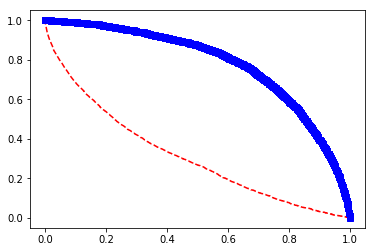

In [78]:
import matplotlib.pyplot as plt
plt.plot(thresholds, fpr, 'r--', thresholds, tpr, 'bs')

El umbral de clasificación es elegido en el punto en donde la diferencia entre False positive rate y True positive rate es máxima.

Finalmente, el accuracy obtenido es:

In [79]:
sum(accuracy)/len(accuracy)

81.39